24520270 - Huỳnh Phát Đạt  
DS201.Q11.1  
Bài thực hành số 3 - EDA Dataset trước khi xây dựng model

## Import thư viện


In [ ]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=f9b8b143629566ed2238868f7f880853136edae0430f6aea2ecc8d303692c92d
  Stored in directory: /root/.cache/pip/wheels/6f/19/20/ec7083125fd06db1a19d0d3ca18806ecf4e8ed1464713b4efa
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2025-11-24 07:25:16--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2025-11-24 07:25:17 (201 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2025-11-24 07:25:17--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from vncorenlp import VnCoreNLP

## **UIT-VSFC**

### 1. Kiểm tra cấu trúc bộ dữ liệu

#### Đọc dữ liệu

In [ ]:
train_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-train.json')
dev_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-dev.json')
test_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-test.json')

#### Kiểm tra các cột

In [ ]:
# các cột chứa trong dataset
print('Train set columns:', train_vsfc.columns)
print('Dev set columns:', dev_vsfc.columns)
print('Test set columns:', test_vsfc.columns)

Train set columns: Index(['sentence', 'sentiment', 'topic'], dtype='object')
Dev set columns: Index(['sentence', 'sentiment', 'topic'], dtype='object')
Test set columns: Index(['sentence', 'sentiment', 'topic'], dtype='object')


#### Kiểm tra missing value

In [ ]:
# in số lượng missing value trên từng cột của từng tập train dev test
print('Missing value in train set:')
print(train_vsfc.isnull().sum())
print('\n==========================================================\n')
print('Missing value in dev set:')
print(dev_vsfc.isnull().sum())
print('\n==========================================================\n')
print('Missing value in test set:')
print(test_vsfc.isnull().sum())

Missing value in train set:
sentence     0
sentiment    0
topic        0
dtype: int64


Missing value in dev set:
sentence     0
sentiment    0
topic        0
dtype: int64


Missing value in test set:
sentence     0
sentiment    0
topic        0
dtype: int64


#### Kiểm tra số lượng mẫu

In [ ]:
print('Train set num_sample:', train_vsfc.shape[0])
print('Dev set num_sample:', dev_vsfc.shape[0])
print('Test set num_sample:', test_vsfc.shape[0])

Train set num_sample: 11426
Dev set num_sample: 1583
Test set num_sample: 3166


#### In ra 10 mẫu dữ liệu đầu tiên

In [ ]:
train_vsfc.head(10)

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,positive,training_program
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,lecturer
2,đi học đầy đủ full điểm chuyên cần .,negative,training_program
3,chưa áp dụng công nghệ thông tin và các thiết ...,negative,lecturer
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,lecturer
5,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive,lecturer
6,"em sẽ nợ môn này , nhưng em sẽ học lại ở các h...",neutral,others
7,"thời lượng học quá dài , không đảm bảo tiếp th...",negative,training_program
8,"nội dung môn học có phần thiếu trọng tâm , hầu...",negative,training_program
9,cần nói rõ hơn bằng cách trình bày lên bảng th...,negative,training_program


In [ ]:
# kiểm tra unique value của tập nhãn
print('Unique value of sentiment:', train_vsfc['sentiment'].unique())
print('Unique value of topic:', train_vsfc['topic'].unique())

Unique value of sentiment: ['positive' 'negative' 'neutral']
Unique value of topic: ['training_program' 'lecturer' 'others' 'facility']


### 2. Phân tích phân bố nhãn

In [ ]:
train_vsfc_sentiment = train_vsfc['sentiment']
dev_vsfc_sentiment = dev_vsfc['sentiment']
test_vsfc_sentiment = test_vsfc['sentiment']

train_vsfc_topic = train_vsfc['topic']
dev_vsfc_topic = dev_vsfc['topic']
test_vsfc_topic = test_vsfc['topic']

#### Thống kê tần suất nhãn

In [ ]:
# hàm in thống kê tập nhãn
def print_distribution(df, label, name):
    print(f'Phân bố nhãn {label} trong tập {name}:')

    counts = df[label].value_counts()
    percents = df[label].value_counts(normalize=True) * 100

    result = pd.DataFrame({
        'count': counts,
        'percent (%)': percents.round(3)
    })

    print(result)
    print('\n==========================================================\n')

In [ ]:
# thống kê tập nhãn sentiment
print_distribution(train_vsfc, 'sentiment', 'train')
print_distribution(dev_vsfc, 'sentiment', 'dev')
print_distribution(test_vsfc, 'sentiment', 'test')

Phân bố nhãn sentiment trong tập train:
           count  percent (%)
sentiment                    
positive    5643       49.387
negative    5325       46.604
neutral      458        4.008


Phân bố nhãn sentiment trong tập dev:
           count  percent (%)
sentiment                    
positive     805       50.853
negative     705       44.536
neutral       73        4.611


Phân bố nhãn sentiment trong tập test:
           count  percent (%)
sentiment                    
positive    1590       50.221
negative    1409       44.504
neutral      167        5.275




In [ ]:
# thống kê tập nhãn topic
print_distribution(train_vsfc, 'topic', 'train')
print_distribution(dev_vsfc, 'topic', 'dev')
print_distribution(test_vsfc, 'topic', 'test')

Phân bố nhãn topic trong tập train:
                  count  percent (%)
topic                               
lecturer           8166       71.469
training_program   2201       19.263
others              562        4.919
facility            497        4.350


Phân bố nhãn topic trong tập dev:
                  count  percent (%)
topic                               
lecturer           1151       72.710
training_program    267       16.867
others               95        6.001
facility             70        4.422


Phân bố nhãn topic trong tập test:
                  count  percent (%)
topic                               
lecturer           2290       72.331
training_program    572       18.067
others              159        5.022
facility            145        4.580




#### Biểu đồ (bar chart) phân bố nhãn

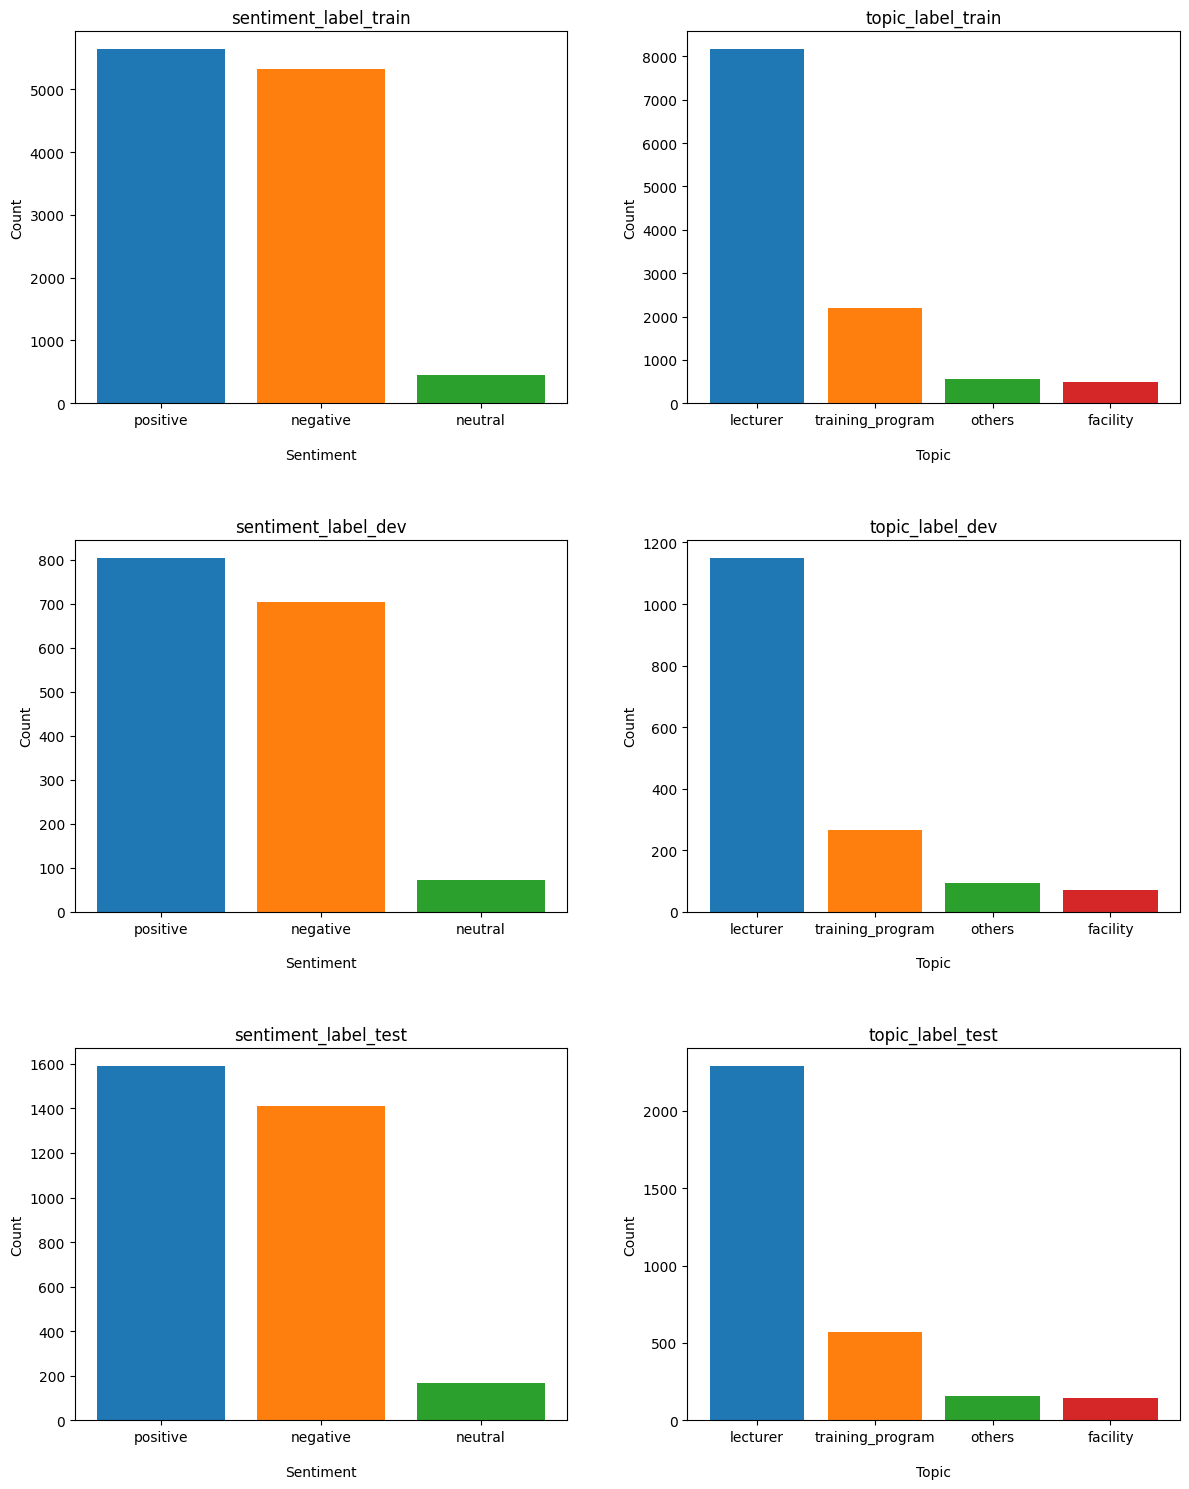

In [ ]:
# Biểu đồ thống kê nhãn trên toàn dataset

train_sent_counts = train_vsfc['sentiment'].value_counts()
train_topic_counts = train_vsfc['topic'].value_counts()
dev_sent_counts = dev_vsfc['sentiment'].value_counts()
dev_topic_counts = dev_vsfc['topic'].value_counts()
test_sent_counts = test_vsfc['sentiment'].value_counts()
test_topic_counts = test_vsfc['topic'].value_counts()

color1 = plt.cm.tab10(np.arange(len(train_sent_counts)))
color2 = plt.cm.tab10(np.arange(len(train_topic_counts)))

plt.figure(figsize=(12, 15))

plt.subplot(3, 2, 1)
plt.bar(train_sent_counts.index, train_sent_counts.values, color=color1)
plt.title("sentiment_label_train")
plt.xlabel("Sentiment", labelpad=15)
plt.ylabel("Count")

plt.subplot(3, 2, 2)
plt.bar(train_topic_counts.index, train_topic_counts.values, color=color2)
plt.title("topic_label_train")
plt.xlabel("Topic", labelpad=15)
plt.ylabel("Count")

plt.subplot(3, 2, 3)
plt.bar(dev_sent_counts.index, dev_sent_counts.values, color=color1)
plt.title("sentiment_label_dev")
plt.xlabel("Sentiment", labelpad=15)
plt.ylabel("Count")

plt.subplot(3, 2, 4)
plt.bar(dev_topic_counts.index, dev_topic_counts.values, color=color2)
plt.title("topic_label_dev")
plt.xlabel("Topic", labelpad=15)
plt.ylabel("Count")

plt.subplot(3, 2, 5)
plt.bar(test_sent_counts.index, test_sent_counts.values, color=color1)
plt.title("sentiment_label_test")
plt.xlabel("Sentiment", labelpad=15)
plt.ylabel("Count")

plt.subplot(3, 2, 6)
plt.bar(test_topic_counts.index, test_topic_counts.values, color=color2)
plt.title("topic_label_test")
plt.xlabel("Topic", labelpad=15)
plt.ylabel("Count")

plt.tight_layout(w_pad=4, h_pad=4)
plt.show()

#### Trả lời câu hỏi: Bộ dữ liệu có bị mất cân bằng nhãn không?

**Bộ dữ liệu bị mất cân bằng nhãn nặng ở cả hai loại nhãn sentiment và topic.**

**1. Phân bố của nhãn topic:** bị mất cân bằng nghiêm trọng
  * Lớp Đa Số Áp Đảo: Nhãn lecturer (giảng viên) chiếm ưu thế tuyệt đối, chiếm hơn 70% số lượng mẫu trong toàn bộ bộ dữ liệu.
  * Các Lớp Thiểu Số: Các nhãn còn lại như training_program (chương trình đào tạo), others (khác), và đặc biệt là facility (cơ sở vật chất) chỉ chiếm một phần rất nhỏ (lớp facility chỉ chiếm khoảng 4% - 5%).

**2. Phân bố nhãn sentiment:** mặc dù ít nghiêm trọng hơn nhưng vẫn tồn tại sự mất cân bằng rõ rệt:
  * Hai nhãn chính là positive (tích cực) và negative (tiêu cực) có số lượng mẫu khá đồng đều, chiếm khoảng 45% - 50% mỗi nhãn.
  * Nhãn neutral (trung tính) là lớp thiểu số rõ rệt, chỉ chiếm khoảng 4% - 5% tổng số mẫu.




### 3. Phân tích độ dài câu

#### Số token/word trong từng câu.

In [ ]:
train_vsfc_num_tokens = train_vsfc['sentence'].apply(lambda x: len(x.split()))
dev_vsfc_num_tokens = dev_vsfc['sentence'].apply(lambda x: len(x.split()))
test_vsfc_num_tokens = test_vsfc['sentence'].apply(lambda x: len(x.split()))

print('Train set sentence length statistics:')
print(train_vsfc_num_tokens.describe())
print('\n===================================================\n')
print('\nDev set sentence length statistics:')
print(dev_vsfc_num_tokens.describe())
print('\n===================================================\n')
print('\nTest set sentence length statistics:')
print(test_vsfc_num_tokens.describe())

Train set sentence length statistics:
count    11426.000000
mean        14.308769
std         10.089727
min          2.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        159.000000
Name: sentence, dtype: float64



Dev set sentence length statistics:
count    1583.000000
mean       13.671510
std         9.912805
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max       161.000000
Name: sentence, dtype: float64



Test set sentence length statistics:
count    3166.000000
mean       14.220783
std        10.242381
min         2.000000
25%         8.000000
50%        11.000000
75%        17.000000
max        98.000000
Name: sentence, dtype: float64


#### Biểu đồ thống kê độ dài câu

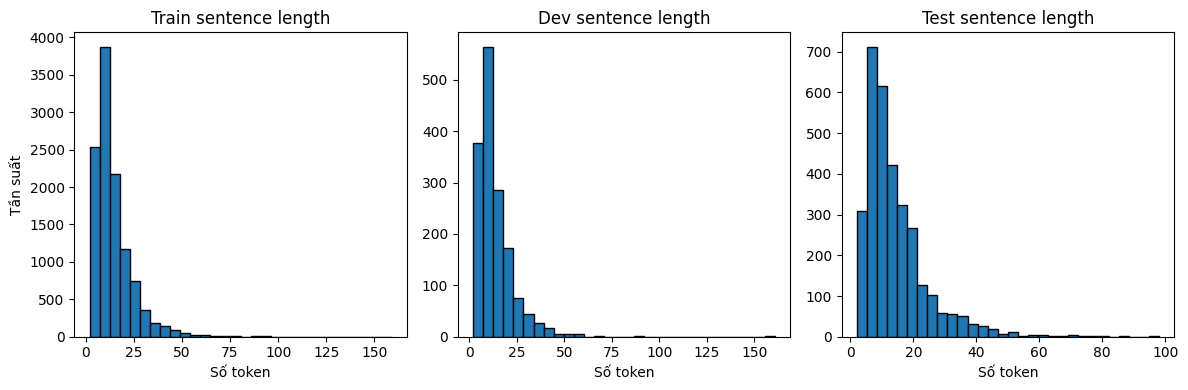

In [ ]:
# Histogram chart

plt.figure(figsize=(12, 4))
# train
plt.subplot(1, 3, 1)
plt.hist(train_vsfc_num_tokens, bins=30, edgecolor='black')
plt.title("Train sentence length")
plt.xlabel("Số token")
plt.ylabel("Tần suất")

# dev
plt.subplot(1, 3, 2)
plt.hist(dev_vsfc_num_tokens, bins=30, edgecolor='black')
plt.title("Dev sentence length")
plt.xlabel("Số token")

# test
plt.subplot(1, 3, 3)
plt.hist(test_vsfc_num_tokens, bins=30, edgecolor='black')
plt.title("Test sentence length")
plt.xlabel("Số token")

plt.tight_layout()
plt.show()

/tmp/ipython-input-743473266.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


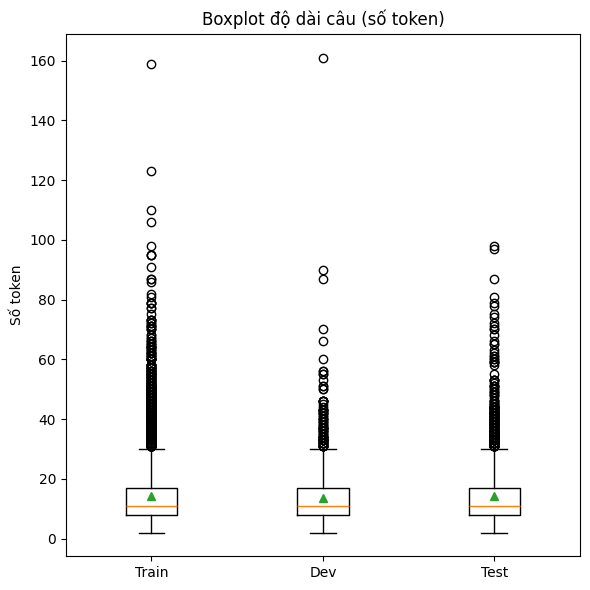

In [ ]:
# Boxplot chart
plt.figure(figsize=(6, 6))
plt.boxplot(
    [train_vsfc_num_tokens, dev_vsfc_num_tokens, test_vsfc_num_tokens],
    labels=["Train", "Dev", "Test"],
    showmeans=True
)
plt.title("Boxplot độ dài câu (số token)")
plt.ylabel("Số token")
plt.tight_layout()
plt.show()

#### Tìm: Max sequence length hợp lý khi padding (ví dụ: 50, 100, 200).

**100 token** là một lựa chọn tốt trong trường hợp này vì nó đạt được sự cân bằng giữa việc giữ lại thông tin và tối ưu hóa hiệu suất tính toán.

**1. Bao phủ gần như toàn bộ dữ liệu:**
  * Hầu như các câu trong bộ dữ liệu đều có độ dài dưới 100 token (chỉ có 1 con số rất rất ít >100) và chúng chưa được tách từ. Vì vậy, sau khi tách từ thì 100 sẽ đảm bảo là độ dài padding hợp lý.

**2. Tránh lãng phí tính toán:**
  * Nếu chọn độ dài lớn hơn (ví dụ: 160 hoặc 200), các câu ngắn sẽ được đệm (padding) quá nhiều token rỗng.
  * Padding quá mức làm tăng đáng kể bộ nhớ cần thiết và kéo dài thời gian huấn luyện mô hình một cách không cần thiết, đặc biệt là với các mô hình phức tạp.

### 4. Thống kê từ vựng

#### Đếm số lượng từ vựng (unique tokens).

In [ ]:
# hàm tạo list các từ xuất hiện trong dữ liệu
def tokenize_column(column):
  all_words = []
  for sentence in column:
      words = str(sentence).split()
      all_words.extend(words)
  return all_words

In [ ]:
train_words = tokenize_column(train_vsfc['sentence'])
train_words = pd.Series(train_words)
dev_words = tokenize_column(dev_vsfc['sentence'])
dev_words = pd.Series(dev_words)
test_words = tokenize_column(test_vsfc['sentence'])
test_words = pd.Series(test_words)

In [ ]:
print('Num of unique_token in train:', len(train_words.unique()))
print('Num of unique_token in dev:', len(dev_words.unique()))
print('Num of unique_token in test:', len(test_words.unique()))

Num of unique_token in train: 2514
Num of unique_token in dev: 1157
Num of unique_token in test: 1581


#### Top 20 từ xuất hiện nhiều nhất

In [ ]:
# hàm in top 20 token xuất hiện nhiều nhất
def top20_token(df, name):
    print(f'Top 20 token xuất hiện nhiều nhất trong tập {name}:')

    counts = df.value_counts().head(20)
    percents = df.value_counts(normalize=True).head(20)*100

    result = pd.DataFrame({
        'count': counts,
        'percent (%)': percents.round(3)
    })

    print(result)
    print('\n==========================================================\n')

In [ ]:
top20_token(train_words, 'train')
top20_token(dev_words, 'dev')
top20_token(test_words, 'test')

Top 20 token xuất hiện nhiều nhất trong tập train:
       count  percent (%)
.      11009        6.734
,       6827        4.176
viên    4803        2.938
giảng   3711        2.270
dạy     3156        1.930
thầy    3095        1.893
sinh    3082        1.885
học     2940        1.798
bài     2336        1.429
tình    2266        1.386
không   2177        1.332
và      2068        1.265
có      2031        1.242
rất     1961        1.199
nhiệt   1931        1.181
cho     1735        1.061
hiểu    1730        1.058
nhiều   1622        0.992
tập     1454        0.889
dễ      1438        0.880


Top 20 token xuất hiện nhiều nhất trong tập dev:
       count  percent (%)
.       1528        7.060
,        948        4.380
viên     644        2.976
giảng    543        2.509
dạy      459        2.121
thầy     415        1.918
sinh     400        1.848
học      366        1.691
bài      328        1.516
tình     321        1.483
nhiệt    282        1.303
rất      280        1.294
không    271  

#### Trả lời câu hỏi: Có cần làm preprocessing không?

Cần phải làm preprocessing ở tất cả các cột:

*   Cột Sentences: cần phải định dạng về chữ in thường để đồng nhất trong việc xây dựng bộ từ vựng cũng như word_to_index,.... phục vụ cho việc encode dữ liệu để xây dựng và huấn luyện model.
*   Cột Sentiment, Topic: cần xóa khoảng trắng thừa, định dạng tất cả về chữ thường trước khi tiến hành encode các nhãn về dạng categorical để đảm bảo không bị xót. Đồng thời chuyển về dạng categorical nhằm phục vụ cho việc xây dựng và huấn luyện model.



### 5. Tiền xử lý dữ liệu

In [ ]:
# chia dữ liệu vào các biến X, y
X_train_vsfc = train_vsfc['sentence']
y_train_vsfc_sent = train_vsfc['sentiment']
y_train_vsfc_topic = train_vsfc['topic']

X_dev_vsfc = dev_vsfc['sentence']
y_dev_vsfc_sent = dev_vsfc['sentiment']
y_dev_vsfc_topic = dev_vsfc['topic']

X_test_vsfc = test_vsfc['sentence']
y_test_vsfc_sent = test_vsfc['sentiment']
y_test_vsfc_topic = test_vsfc['topic']

#### Biến đổi và xử lý tập nhãn

In [ ]:
# hàm replace giá trị trong tập nhãn sentiment
def encode_sentiment(series):
  mapping = {
    "positive": 2,
    "neutral": 1,
    "negative": 0
  }

  # định dạng kiểu dữ liệu str
  # xóa khoảng trắng thừa
  # định dạng chữ in thường
  # map giá trị theo dictionary mapping
  encoded_series = series.astype(str).str.strip().str.lower().map(mapping)

  if encoded_series.isnull().any():
      print(f"Warning: {encoded_series.isnull().sum()} NaN values found after encoding sentiments label")

  return encoded_series

In [ ]:
train_vsfc['sentiment_encoded'] = encode_sentiment(train_vsfc['sentiment'])
dev_vsfc['sentiment_encoded'] = encode_sentiment(dev_vsfc['sentiment'])
test_vsfc['sentiment_encoded'] = encode_sentiment(test_vsfc['sentiment'])

In [ ]:
# hàm replace giá trị trong tập nhãn topic
def encode_topic(series):
  mapping = {
      "training_program": 0,
      "others": 1,
      "facility": 2,
      "lecturer": 3
  }

  # định dạng kiểu dữ liệu str
  # xóa khoảng trắng thừa
  # định dạng chữ in thường
  # map giá trị theo dictionary mapping
  encoded_series = series.astype(str).str.strip().str.lower().map(mapping)

  if encoded_series.isnull().any():
      print(f"Warning: {encoded_series.isnull().sum()} NaN values found after encoding topic label")

  return encoded_series

In [ ]:
train_vsfc['topic_encoded'] = encode_topic(train_vsfc['topic'])
dev_vsfc['topic_encoded'] = encode_topic(dev_vsfc['topic'])
test_vsfc['topic_encoded'] = encode_topic(test_vsfc['topic'])

#### Tách từ tập sentence với VnCoreNLP

In [ ]:
vncorenlp = VnCoreNLP(
    "/content/vncorenlp/VnCoreNLP-1.1.1.jar",
    annotators="wseg",
    max_heap_size='-Xmx500m'
)

# hàm tách từ bằng VnCoreNLP
def custom_tokenizer(text):
    tokens = vncorenlp.tokenize(str(text))[0]
    return " ".join(tokens)

In [ ]:
# Xây dựng bộ từ vựng của dataset dựa trên tập train
word_dict = set()

for sent in X_train_vsfc:
    ws = custom_tokenizer(sent).lower()
    for w in ws.split():
        word_dict.add(w)

# Tạo word2index
words = list(word_dict)

word2index = {w: i+2 for i, w in enumerate(words)}
word2index["UNK"] = 1
word2index["PAD"] = 0

In [ ]:
# độ dài câu padding đã chọn ở phía trên
MAX_LEN = 100

def encoding(X):
  sentences = []
  for t in X:
    sentences.append(custom_tokenizer(t))

  X = []
  for s in sentences:
    sent = []
    for w in s.split():
      try:
        w = w.lower()
        sent.append(word2index[w])
      except:
        sent.append(word2index["UNK"])
    X.append(sent)

  X = pad_sequences(maxlen = MAX_LEN, sequences = X,
                    padding = "post", value = word2index["PAD"])

  return (X)

In [ ]:
# encode sentence
X_train_encoded = encoding(X_train_vsfc)
X_dev_encoded = encoding(X_dev_vsfc)
X_test_encoded = encoding(X_test_vsfc)

# encode sentiment label
y_train_sent_encoded = to_categorical(train_vsfc['sentiment_encoded'], num_classes=3)
y_dev_sent_encoded = to_categorical(dev_vsfc['sentiment_encoded'], num_classes=3)
y_test_sent_encoded  = to_categorical(test_vsfc['sentiment_encoded'], num_classes=3)

# encode topic label
y_train_topic_encoded = to_categorical(train_vsfc['topic_encoded'], num_classes=4)
y_dev_topic_encoded = to_categorical(dev_vsfc['topic_encoded'], num_classes=4)
y_test_topic_encoded = to_categorical(test_vsfc['topic_encoded'], num_classes=4)

#### Minh họa dữ liệu trước và sau tiền xử lý

In [ ]:
# In dữ liệu trước tiền xử lý
print('Before Preprocessing:')
print(train_vsfc[['sentence', 'sentiment', 'topic']].head(10))

print('\n==========================================================\n')

# In dữ liệu sau tiền xử lý
print('After Preprocessing:')
print('Sentence:\n', X_train_encoded[:10])
print('Sentiment:\n', y_train_sent_encoded[:10])
print('Topic:\n', y_train_topic_encoded[:10])

Before Preprocessing:
                                            sentence sentiment  \
0                          slide giáo trình đầy đủ .  positive   
1     nhiệt tình giảng dạy , gần gũi với sinh viên .  positive   
2               đi học đầy đủ full điểm chuyên cần .  negative   
3  chưa áp dụng công nghệ thông tin và các thiết ...  negative   
4  thầy giảng bài hay , có nhiều bài tập ví dụ ng...  positive   
5  giảng viên đảm bảo thời gian lên lớp , tích cự...  positive   
6  em sẽ nợ môn này , nhưng em sẽ học lại ở các h...   neutral   
7  thời lượng học quá dài , không đảm bảo tiếp th...  negative   
8  nội dung môn học có phần thiếu trọng tâm , hầu...  negative   
9  cần nói rõ hơn bằng cách trình bày lên bảng th...  negative   

              topic  
0  training_program  
1          lecturer  
2  training_program  
3          lecturer  
4          lecturer  
5          lecturer  
6            others  
7  training_program  
8  training_program  
9  training_program  


After P

## **PhoNER**

### 1. Kiểm tra cấu trúc dữ liệu

#### Tải dữ liệu

In [ ]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 61 (delta 24), reused 41 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 3.61 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (24/24), done.


#### Đọc dữ liệu

In [ ]:
train_PhoNER = pd.read_json('/content/PhoNER_COVID19/data/word/train_word.json', lines=True)
dev_PhoNER = pd.read_json('/content/PhoNER_COVID19/data/word/dev_word.json', lines=True)
test_PhoNER = pd.read_json('/content/PhoNER_COVID19/data/word/test_word.json', lines=True)

#### In ra 20 mẫu dữ liệu đầu tiên

In [ ]:
# In ra 20 mẫu dữ liệu đầu tiên của tập train
train_PhoNER.head(20)

,words,tags
0,"[Đồng_thời, ,, bệnh_viện, tiếp_tục, thực_hiện,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"["", Số, bệnh_viện, có_thể, tiếp_nhận, bệnh_nhâ...","[O, O, O, O, O, O, O, B-SYMPTOM_AND_DISEASE, I..."
2,"[Ngoài_ra, ,, những, người, tiếp_xúc, gián_tiế...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Bà, này, khi, trở, về, quá_cảnh, Doha, (, Qat...","[O, O, O, O, O, O, B-LOCATION, O, B-LOCATION, ..."
4,"["", Bệnh_nhân, 523, "", và, chồng, là, "", bệnh_...","[O, O, B-PATIENT_ID, O, O, O, O, O, O, B-PATIE..."
5,"[Trường_hợp, bệnh_nhân, 188, L.T.H., ,, theo, ...","[O, O, B-PATIENT_ID, B-NAME, O, O, O, O, O, O,..."
6,"[Riêng, bệnh_nhân, 91, là, phi_công, người, An...","[O, O, B-PATIENT_ID, O, B-JOB, O, O, O, O, B-L..."
7,"[Bệnh_nhân, đã, được, xét_nghiệm, có, 3, kết_q...","[O, O, O, O, O, O, O, O, O, O, O, B-DATE, O, B..."
8,"[Bà, đã, tiếp_xúc, với, người_thân, xác_định, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOCA..."
9,"[Chiều, 22, -, 4, ,, bệnh_nhân, được, cho, về,...","[O, B-DATE, I-DATE, I-DATE, O, O, O, O, O, O, ..."


#### Unique value của cột tag

In [ ]:
# lấy unique value cột tags
train_unique_tags = set(tag for seq in train_PhoNER['tags'] for tag in seq)
dev_unique_tags = set(tag for seq in dev_PhoNER['tags'] for tag in seq)
test_unique_tags = set(tag for seq in test_PhoNER['tags'] for tag in seq)


In [ ]:
# in ra Unique value của cột tags
print("Train unique tags:", train_unique_tags)
print("Dev unique tags:", dev_unique_tags)
print("Test unique tags:", test_unique_tags)

Train unique tags: {'B-JOB', 'I-NAME', 'B-TRANSPORTATION', 'I-ORGANIZATION', 'B-PATIENT_ID', 'I-TRANSPORTATION', 'I-PATIENT_ID', 'B-DATE', 'I-LOCATION', 'I-DATE', 'B-GENDER', 'I-SYMPTOM_AND_DISEASE', 'I-AGE', 'B-ORGANIZATION', 'O', 'B-LOCATION', 'B-NAME', 'B-SYMPTOM_AND_DISEASE', 'I-JOB', 'B-AGE'}
Dev unique tags: {'B-JOB', 'I-NAME', 'B-TRANSPORTATION', 'I-ORGANIZATION', 'B-PATIENT_ID', 'I-TRANSPORTATION', 'I-PATIENT_ID', 'B-DATE', 'I-LOCATION', 'I-DATE', 'B-GENDER', 'I-SYMPTOM_AND_DISEASE', 'B-ORGANIZATION', 'O', 'B-LOCATION', 'B-NAME', 'B-SYMPTOM_AND_DISEASE', 'I-JOB', 'B-AGE'}
Test unique tags: {'B-JOB', 'I-NAME', 'B-TRANSPORTATION', 'I-ORGANIZATION', 'B-PATIENT_ID', 'I-TRANSPORTATION', 'I-PATIENT_ID', 'B-DATE', 'I-LOCATION', 'I-DATE', 'B-GENDER', 'I-SYMPTOM_AND_DISEASE', 'I-AGE', 'B-ORGANIZATION', 'O', 'B-LOCATION', 'B-NAME', 'B-SYMPTOM_AND_DISEASE', 'I-JOB', 'B-AGE'}


In [ ]:
# số lượng unique value của tags trong từng tập
print("Num of train unique tags:", len(train_unique_tags))
print("Num of dev unique tags:", len(dev_unique_tags))
print("Num of test unique tags:", len(test_unique_tags))

Num of train unique tags: 20
Num of dev unique tags: 19
Num of test unique tags: 20


### 2. Thống kê số câu trong từng tập

#### Số câu trong train/dev/test

In [ ]:
print('Số câu trong tập train:', len(train_PhoNER['words']))
print('Số câu trong tập dev:', len(dev_PhoNER['words']))
print('Số câu trong tập test:', len(test_PhoNER['words']))

Số câu trong tập train: 5027
Số câu trong tập dev: 2000
Số câu trong tập test: 3000


#### Số lượng token mỗi tập

In [ ]:
# lấy số token trong mỗi câu
train_PhoNER_num_tokens = train_PhoNER['words'].apply(lambda x: len(x))
dev_PhoNER_num_tokens = dev_PhoNER['words'].apply(lambda x: len(x))
test_PhoNER_num_tokens = test_PhoNER['words'].apply(lambda x: len(x))

# tính tổng số token trong các tập
train_PhoNER_total_tokens = train_PhoNER_num_tokens.sum()
dev_PhoNER_total_tokens = dev_PhoNER_num_tokens.sum()
test_PhoNER_total_tokens = test_PhoNER_num_tokens.sum()

In [ ]:
print('Số lượng token trong tập train:', train_PhoNER_total_tokens)
print('Số lượng token trong tập dev:', dev_PhoNER_total_tokens)
print('Số lượng token trong tập test:', test_PhoNER_total_tokens)

Số lượng token trong tập train: 132511
Số lượng token trong tập dev: 56283
Số lượng token trong tập test: 85678


### 3. Phân bố nhãn thực thể

#### Thống kê số lần xuất hiện của từng nhãn (B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, O,...)

In [ ]:
# hàm in thống kê số lần xuất hiện của từng nhãn
def PhoNER_label_statistical(df, name):
  df = df.explode()
  print(f'Thống kê sự xuất hiện của từng nhãn trong tập {name}:')

  counts = df.value_counts()
  percents = df.value_counts(normalize=True)*100

  result = pd.DataFrame({
      'count': counts,
      'percent (%)': percents.round(3)
  })

  print(result)
  print('\n==========================================================\n')

In [ ]:
PhoNER_label_statistical(train_PhoNER['tags'], 'train')
PhoNER_label_statistical(dev_PhoNER['tags'], 'dev')
PhoNER_label_statistical(test_PhoNER['tags'], 'test')

Thống kê sự xuất hiện của từng nhãn trong tập train:
                        count  percent (%)
tags                                      
O                      104750       79.050
B-LOCATION               5398        4.074
I-LOCATION               5242        3.956
B-PATIENT_ID             3240        2.445
B-DATE                   2549        1.924
I-ORGANIZATION           2545        1.921
I-DATE                   2500        1.887
I-SYMPTOM_AND_DISEASE    1552        1.171
B-SYMPTOM_AND_DISEASE    1439        1.086
B-ORGANIZATION           1137        0.858
B-AGE                     682        0.515
B-GENDER                  542        0.409
B-NAME                    349        0.263
B-TRANSPORTATION          226        0.171
B-JOB                     205        0.155
I-TRANSPORTATION           67        0.051
I-JOB                      62        0.047
I-NAME                     13        0.010
I-PATIENT_ID               11        0.008
I-AGE                       2        0.002



#### Biểu đồ (bar chart) phân bố nhãn

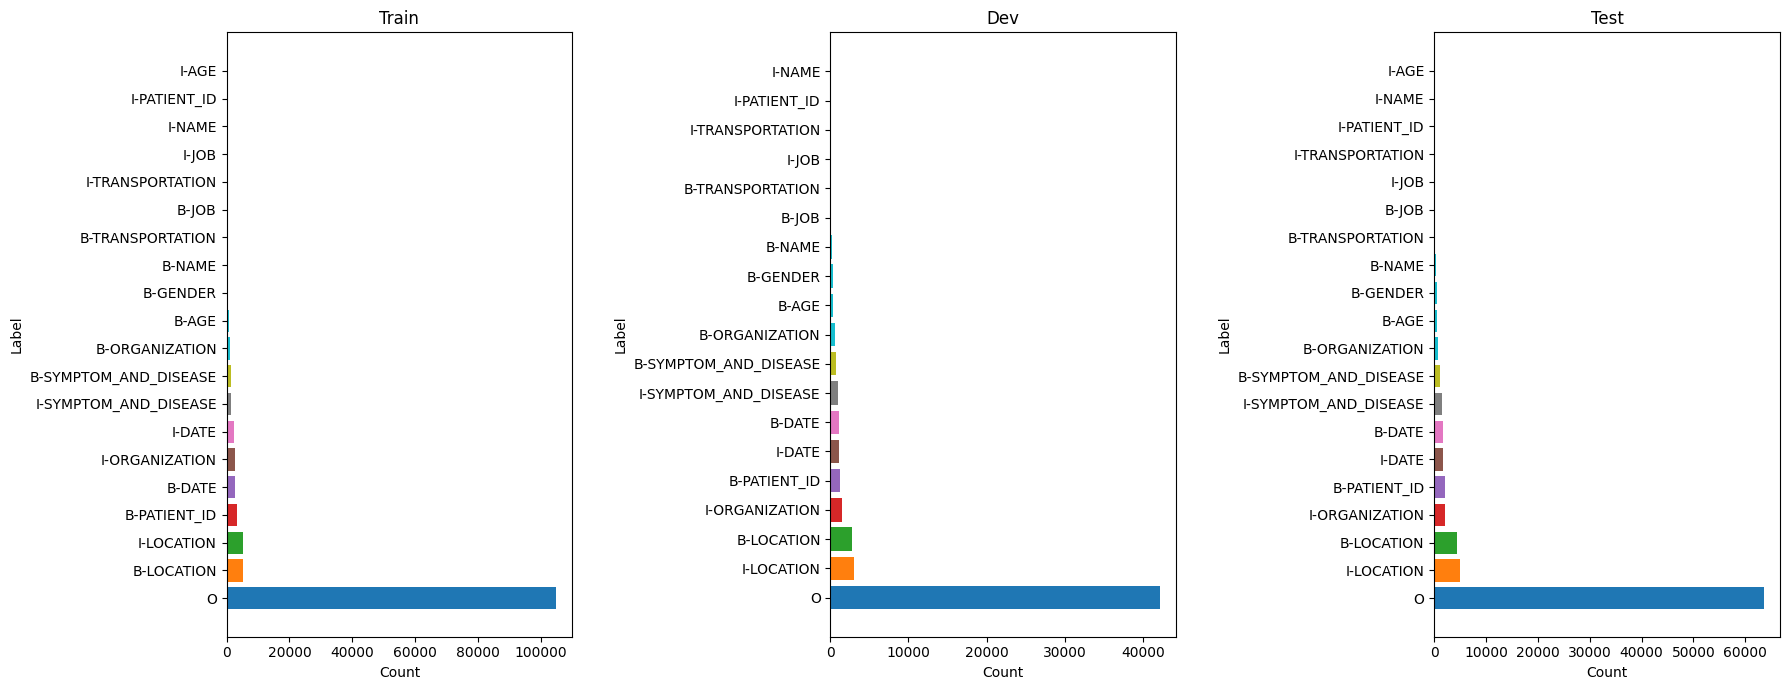

In [ ]:
_train = train_PhoNER['tags'].explode().value_counts()
_dev = dev_PhoNER['tags'].explode().value_counts()
_test = test_PhoNER['tags'].explode().value_counts()

color = plt.cm.tab10(np.arange(len(_train.unique())))

plt.figure(figsize=(18, 7))

plt.subplot(1, 3, 1)
plt.barh(_train.index, _train.values, color=color)
plt.title('Train')
plt.xlabel('Count')
plt.ylabel('Label')

plt.subplot(1, 3, 2)
plt.barh(_dev.index, _dev.values, color=color)
plt.title('Dev')
plt.xlabel('Count')
plt.ylabel('Label')

plt.subplot(1, 3, 3)
plt.barh(_test.index, _test.values, color=color)
plt.title('Test')
plt.xlabel('Count')
plt.ylabel('Label')

plt.tight_layout(w_pad=3)
plt.show()

#### Nhận xét sự xuất hiện của nhãn



*   Nhiều nhất: 0   -   tỉ lệ: ~75% - 79%
*   Nhiều: I-LOCATION, B-LOCATION - tỉ lệ: ~4% - 6%
*   Ít: B-AGE, B-GENDER, B-NAME - tỉ lệ: ~0.2% - 0.7%
*   Hiếm gặp: I-AGE, I-NAME, I-PATIENT_ID - tỉ lệ: ~0.002% - 0.03%



### 4. Phân tích độ dài câu

#### Tính số token cho từng câu

In [ ]:
# lấy số token trong mỗi câu
train_PhoNER_num_tokens = train_PhoNER['words'].apply(lambda x: len(x))
dev_PhoNER_num_tokens = dev_PhoNER['words'].apply(lambda x: len(x))
test_PhoNER_num_tokens = test_PhoNER['words'].apply(lambda x: len(x))

#### Tìm min / max / mean / ...

In [ ]:
print('Train set sentence length statistics:')
print(train_PhoNER_num_tokens.describe())
print('\n===================================================\n')
print('\nDev set sentence length statistics:')
print(dev_PhoNER_num_tokens.describe())
print('\n===================================================\n')
print('\nTest set sentence length statistics:')
print(test_PhoNER_num_tokens.describe())

Train set sentence length statistics:
count    5027.000000
mean       26.359857
std        12.504579
min         6.000000
25%        18.000000
50%        24.000000
75%        32.000000
max       161.000000
Name: words, dtype: float64



Dev set sentence length statistics:
count    2000.000000
mean       28.141500
std        13.466297
min         7.000000
25%        19.000000
50%        25.000000
75%        34.000000
max       138.000000
Name: words, dtype: float64



Test set sentence length statistics:
count    3000.000000
mean       28.559333
std        13.881500
min         7.000000
25%        19.000000
50%        26.000000
75%        35.000000
max       162.000000
Name: words, dtype: float64


#### Biểu đồ thống kê số token

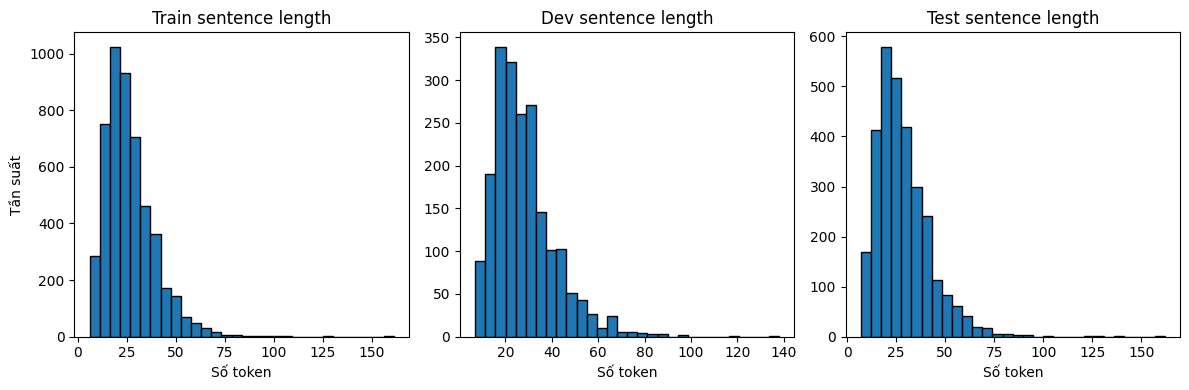

In [ ]:
# Histogram chart

plt.figure(figsize=(12, 4))
# train
plt.subplot(1, 3, 1)
plt.hist(train_PhoNER_num_tokens, bins=30, edgecolor='black')
plt.title("Train sentence length")
plt.xlabel("Số token")
plt.ylabel("Tần suất")

# dev
plt.subplot(1, 3, 2)
plt.hist(dev_PhoNER_num_tokens, bins=30, edgecolor='black')
plt.title("Dev sentence length")
plt.xlabel("Số token")

# test
plt.subplot(1, 3, 3)
plt.hist(test_PhoNER_num_tokens, bins=30, edgecolor='black')
plt.title("Test sentence length")
plt.xlabel("Số token")

plt.tight_layout()
plt.show()

/tmp/ipython-input-2031131311.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


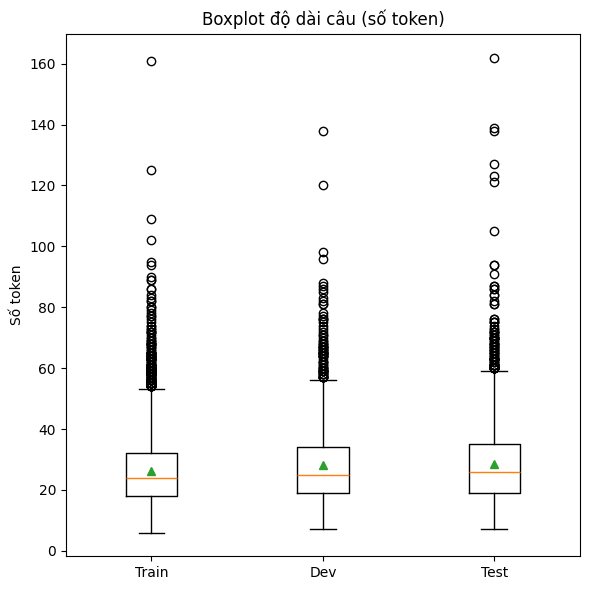

In [ ]:
# Boxplot chart
plt.figure(figsize=(6, 6))
plt.boxplot(
    [train_PhoNER_num_tokens, dev_PhoNER_num_tokens, test_PhoNER_num_tokens],
    labels=["Train", "Dev", "Test"],
    showmeans=True
)
plt.title("Boxplot độ dài câu (số token)")
plt.ylabel("Số token")
plt.tight_layout()
plt.show()

#### Trả lời câu hỏi: padding tối ưu? có câu nào quá dài gây bất lợi cho LSTM?

**70 token** để tiến hành padding là một lựa chọn tốt trong trường hợp này vì:

**1. Bao phủ gần như toàn bộ dữ liệu:**
  * Hầu như số token trong bộ dữ liệu đều có độ dài loanh quanh trong khoảng này (chỉ có một số rất ít là có độ dài lớn hơn).

**2. Tránh lãng phí tính toán:**
  * Nếu chọn độ dài lớn hơn (ví dụ: 160 hoặc 200) để bao phủ đảm bảo bao phủ toàn bộ dữ liệu, sẽ có rất rất nhiều token ngắn được padding gây giảm hiệu quả.
  * Padding quá mức làm tăng đáng kể bộ nhớ cần thiết và kéo dài thời gian huấn luyện mô hình một cách không cần thiết, đặc biệt là với các mô hình phức tạp.